# CH07: Combining Different Models for Ensemble Learning

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), ".."))

## Learning with ensembles

In [2]:
from scipy.special import comb
import math

In [3]:
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [
        comb(n_classifier, k)*(error**k)*(1-error)**(n_classifier-k) 
        for k in range(k_start, n_classifier+1) 
    ]
    return sum(probs)    

In [4]:
ensemble_error(11, 0.25)

0.03432750701904297

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ ensemble_error(11, error) for error in error_range ]

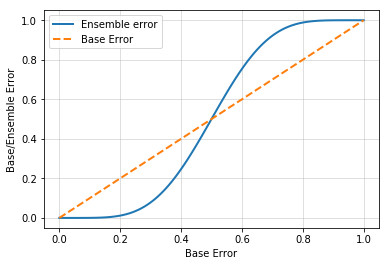

In [7]:
plt.plot(error_range, ens_errors, label="Ensemble error", linewidth=2)
plt.plot(error_range, error_range, linestyle="--", label="Base Error", linewidth=2)
plt.xlabel("Base Error")
plt.ylabel("Base/Ensemble Error")
plt.legend(loc="upper left")
plt.grid(alpha=0.5)
plt.show()

## Combining classifiers via majority vote

In [8]:
from ch07.ensemble import MajorityVoteClassifier

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [9]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]

In [58]:
le = LabelEncoder()
y = le.fit_transform(y)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import numpy as np

In [61]:
clf1 = LogisticRegression(penalty="l2", C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion="entropy", random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric="minkowski")

In [62]:
pipe1 = Pipeline([
    ("sc", StandardScaler()),
    ("clf", clf1)
])

In [63]:
pipe3 = Pipeline([
    ("sc", StandardScaler()),
    ("clf", clf3)
])

In [64]:
clf_labels = [ "Logistic Regression", "Decision Tree", "KNN" ]

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring="roc_auc")
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 1.00 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.97 (+/- 0.05) [Decision Tree]
ROC AUC: 0.99 (+/- 0.04) [KNN]


In [65]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

In [66]:
clf_labels = [ "Logistic Regression", "Decision Tree", "KNN", "Majority Voring" ]

for clf, label in zip([pipe1, clf2, pipe3, mv_clf], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring="roc_auc")
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 1.00 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.97 (+/- 0.05) [Decision Tree]
ROC AUC: 0.99 (+/- 0.04) [KNN]
ROC AUC: 1.00 (+/- 0.00) [Majority Voring]


## Evaluating and tunning the ensemble classifier

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

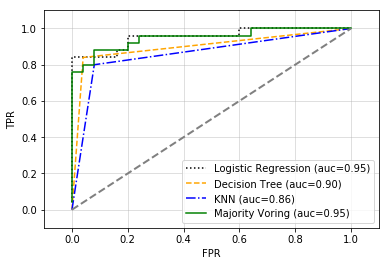

In [20]:
colors = ["black", "orange", "blue", "green"]
linestyles = [ ":", "--", "-.", "-" ]

for clf, label, clr, ls in zip([pipe1, clf2, pipe3, mv_clf], clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label="%s (auc=%0.2f)" % (label, roc_auc))
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [21]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
params = {
    "decisiontreeclassifier__max_depth": [1, 2],
    "pipeline-1__clf__C": [ 0.001, 0.1, 100.0 ]
}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring="roc_auc")
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [24]:
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f +/- %0.2f %r" % (mean_score, scores.std() / 2, params))

0.933 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.03 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.03 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


/media/Data/Projects/PML/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [25]:
grid.best_params_

{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}

In [26]:
grid.best_score_

0.9733333333333334

## Bagging - building an ensemble of classifiers from bootstrap samples

In [27]:
import pandas as pd

In [28]:
wine = datasets.load_wine()

df_wine = pd.DataFrame(wine["data"], columns=wine["feature_names"])
df_wine["Class label"] = wine["target"]
df_wine = df_wine[df_wine["Class label"] != 1]

In [29]:
df_wine.groupby("Class label").size()

Class label
0    59
2    48
dtype: int64

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

y = df_wine["Class label"]
X = df_wine[["alcohol", "od280/od315_of_diluted_wines"]].values

le = LabelEncoder().fit(y)
y = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y, random_state=1)

In [31]:
from sklearn.ensemble import BaggingClassifier

In [32]:
tree = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=None)

bag = BaggingClassifier(
    base_estimator=tree, 
    n_estimators=500, max_samples=1.0, max_features=1.0, 
    bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1
)

In [33]:
from sklearn.metrics import accuracy_score

In [34]:
tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

In [35]:
print("Decision tree train/test accuracy: %.3f/%.3f" % (tree_train, tree_test))

Decision tree train/test accuracy: 1.000/0.977


In [36]:
bag = bag.fit(X_train, y_train)

y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

In [37]:
print("Decision tree train/test accuracy: %.3f/%.3f" % (bag_train, bag_test))

Decision tree train/test accuracy: 1.000/0.977


## Leveraging weak learners via adaptive boosting

In [38]:
from sklearn.ensemble import AdaBoostClassifier

In [39]:
tree = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=1)

ada = AdaBoostClassifier(
    base_estimator=tree, n_estimators=500, learning_rate=0.1,
    random_state=1
)

In [40]:
ada = ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

In [41]:
print("AdaBoost train/test accuracy: %.3f/%.3f" % (ada_train, ada_test))

Decision tree train/test accuracy: 1.000/0.977


## Gradient Boosting

Gradient Boosting is a generalization of boosting to arbitrary differentiable loss function.

In [71]:
from sklearn.ensemble import GradientBoostingClassifier

In [72]:
gbc = GradientBoostingClassifier(n_estimators=1, max_depth=1, random_state=1, learning_rate=0.1)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1, presort='auto',
              random_state=1, subsample=1.0, verbose=0, warm_start=False)

In [73]:
y_train_pred = gbc.predict(X_train)
y_test_pred = gbc.predict(X_test)

gbc_train = accuracy_score(y_train, y_train_pred)
gbc_test = accuracy_score(y_test, y_test_pred)

In [75]:
print("Gradient Boosting train/test accuracy: %.3f/%.3f" % (ada_train, ada_test))

Gradient Boosting train/test accuracy: 1.000/0.977


In [79]:
from sklearn.model_selection import GridSearchCV

In [80]:
gbc.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1,
 'presort': 'auto',
 'random_state': 1,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [92]:
params = {
    "n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
    "learning_rate": np.arange(0.1, 1.1, 0.1),
}

grid = GridSearchCV(estimator=gbc, param_grid=params, cv=5)
grid = grid.fit(X_train, y_train)

In [95]:
grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 10}